In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import preprocessing, cascade
import graph_tool.all as gt
import numpy as np
from IPython.display import Image

# Experimenting with Different Attribution Methods
The standard is this temporal approach. What about the following methods:
- flow graph
- random spanning tree of flow graph 
- least recent retweet
- sampling a distribution based on n_followers
- sampling a distribution based on n_followers^-1
- sampling a uniform distribution based on the # of options

## Debug Network Constructions of Various Types and Implement Structural Virality Calc
1. Establish a base case quasi-interesting case (not too big or small)
2. Check results
3. Structural Virality

In [3]:
test_cascade = cascade.Cascade.from_pickle()

In [5]:
def mini_plotter(g):
    out_deg = g.new_vertex_property('int')
    out_deg.a = np.log(g.get_out_degrees(g.get_vertices())+2)
    
    vtext = g.new_vertex_property('string')
    for i, v in enumerate(g.vertices()):
        vtext[v] = ''
#        if v.out_degree() > text_label_thresh:
        vtext[v] = i#g.vp.vertex_to_tweet[v].username
    
    loc = gt.graphviz_draw(g, layout='dot', vsize=out_deg, 
                           vprops={"label": vtext, 'fontsize': 100},
                           output='temp.png')

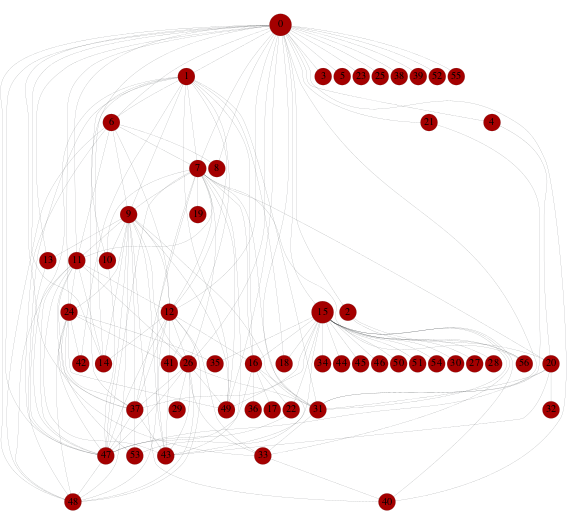

In [6]:
fg = test_cascade.create_network('flow-graph')
mini_plotter(fg)
Image(filename='temp.png')

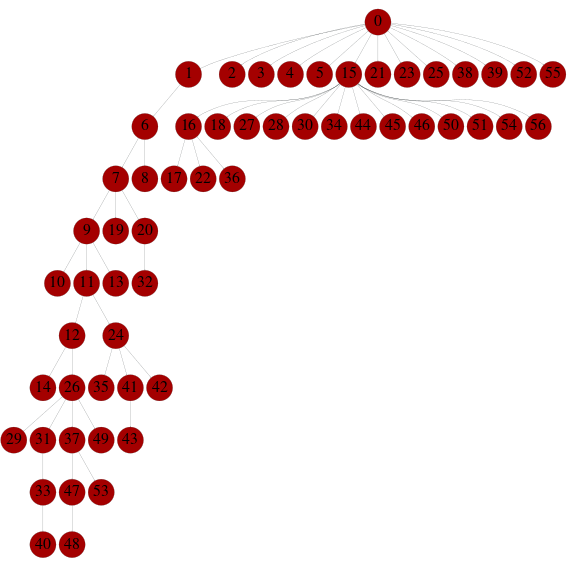

In [7]:
temporal = test_cascade.create_network('temporal')
mini_plotter(temporal)
Image(filename='temp.png')

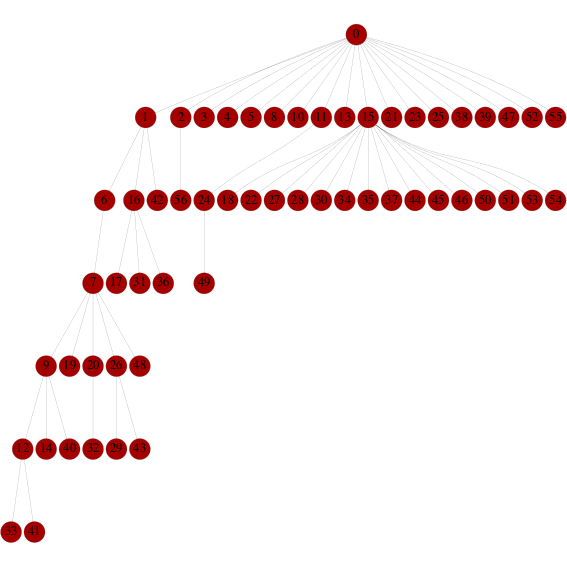

In [8]:
unif = test_cascade.create_network('uniform')
mini_plotter(unif)
Image(filename='temp.png')

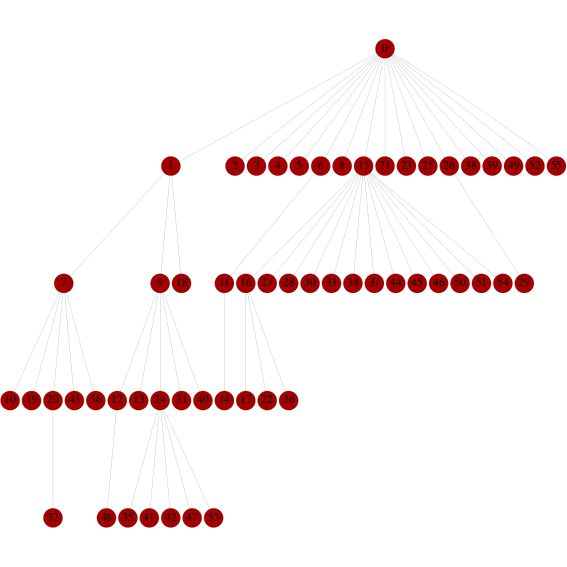

In [25]:
mini_plotter(network)
Image(filename='temp.png')

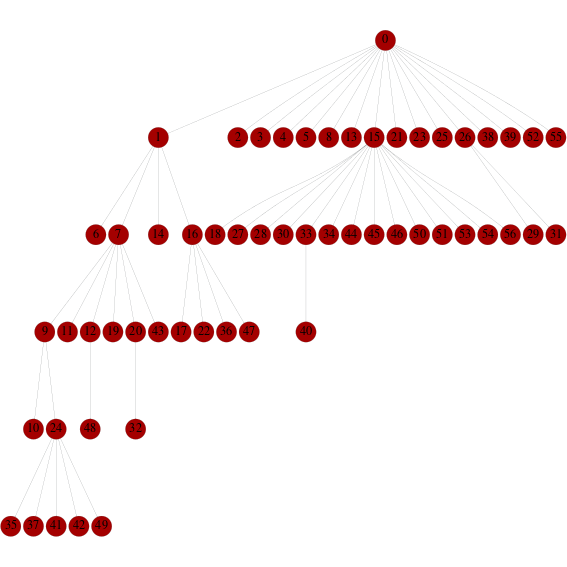

In [18]:
weighted = test_cascade.create_network('proportional-followers', from_memory=False)
mini_plotter(weighted)
Image(filename='temp.png')

# Function to Compute Descendents

In [34]:
def create_descendents_prop_map(g):
    g.vp.n_desc = g.new_vertex_property('int')
    def get_n_descendents(g, v):
        descendents = g.get_out_neighbors(v)
        #print(v, ':', descendents)
        if len(descendents) == 0:
            g.vp.n_desc[v] = 0
        else:
            g.vp.n_desc[v] = len(descendents) + sum([get_n_descendents(g, x) for x in descendents])
        return g.vp.n_desc[v]
    get_n_descendents(g, 0)
    return g.vp.n_desc.a

## Idea
We can generate a bunch of different networks, and explore how they allocate "credit" in a cascade by dividing the descendent arrays by the flow graph. The flow graph n_descendents is the maximal number of credit -> is this true

## Computer Max Descendents for a Node from Flow Graph
This is just the size of the out_component for each node

In [20]:
def max_impressions(fg):
    return np.array([np.sum(gt.label_out_component(fg, v).a) for v in fg.vertices()])
max_impressions(fg)

array([57, 34, 10,  1,  9,  1, 32, 30,  1, 25,  3, 22, 18,  3,  1, 27,  9,
        1,  1,  1,  8,  4,  3,  1, 10,  1, 11,  1,  1,  1,  1,  3,  1,  2,
        1,  1,  1,  5,  1,  1,  1,  2,  1,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  1,  1,  1], dtype=uint64)

### Computing Structural Virality

# Exploration 1: Spanning Trees
Are participants important in the RT cascade under various assumptions

In [21]:
def structural_virality(g_directed):
    # sum over all pairwise distances
    g = gt.GraphView(g_directed, directed=False)
    n = g.num_vertices()
    total = sum([gt.shortest_distance(g, i, j) for i in range(n) for j in range(i+1, n)])
    # multiple by two because we only did half the distances and its symmetric
    return 2*total/(n*n-1)

In [33]:
structural_virality(unif)

3.9667487684729066

In [32]:
structural_virality(temporal)

5.600985221674877

In [31]:
structural_virality(weighted)

3.7746305418719213

### Perhaps structural virality is moderately robust to this... but maybe it shifts influence on particular nodes

In [22]:
max_desc = max_impressions(fg)

In [28]:
unif_desc = create_descendents_prop_map(unif)
temporal_desc = create_descendents_prop_map(temporal)
weighted_desc = create_descendents_prop_map(weighted)

In [29]:
import matplotlib.pyplot as plt

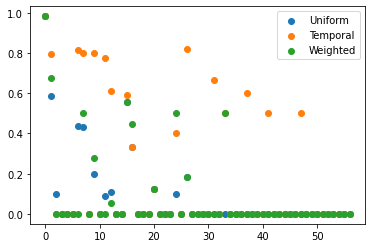

In [30]:
arrays = [unif_desc, temporal_desc, weighted_desc]
labels = ['Uniform', 'Temporal', 'Weighted']
for a,l in zip(arrays, labels):
    plt.scatter(range(len(a)), a/max_desc, label=l)
plt.legend()

# Exploration 2: Impact of Attribution Heuristic on Structural Virality 

## Bulk Building Cascades

In [4]:
def build_cascades(c):
    c.create_network('temporal')
    c.create_network('reverse-temporal')
    c.create_network('flow-graph')
    for i in range(3):
        c.create_network('proportional-followers', suffix=str(i))
        c.create_network('uniform', suffix=str(i))

In [7]:
 from tqdm import tqdm_notebook as tqdm 

In [ ]:
preprocessing.campaign_wide_cascade_apply(build_cascades)

 44%|████▎     | 314/720 [00:40<00:09, 42.85it/s]